In [1]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, BatchNormalization
from keras import regularizers
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing
from functools import reduce


Using TensorFlow backend.


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=100, num_test=0, subtract_mean=True, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2458, 1000, 22) 
y_train: (2458,) 
X_val: (100, 1000, 22) 
y_val: (100,) 
X_test: (0, 1000, 22) 
y_test: (0,) 


In [3]:
# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
X_val = data.get('X_val')
y_val = data.get('y_val')
#X_test = data.get('X_test')
#y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape
#N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
#y_test = lb.transform(y_test)

In [4]:
print(y_val)

[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]

In [5]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [6]:
def downsample(data, mul=10, enableTrunc = False):
    assert data.shape[0] % mul == 0 or  enableTrunc, "Can't downsample without data truncation.\
                                                \n Set another value of mul or set enableTrunc = True"
    outdata = []
    for i in range(data.shape[0]//mul):
        outdata.append(np.mean(data[i*mul:(i+1)*mul,...], axis=0, keepdims=True))
    outdata = reduce(lambda a,b: np.append(a,b,0), outdata)
    
    return outdata
span = 2
X_train_sub = np.expand_dims(downsample(X_train[0,:,:], mul=span),axis=0)
for n in np.arange(1,X_train.shape[0]):
    X_train_sub = np.append(X_train_sub,
                            np.expand_dims(downsample(X_train[n,:,:], mul=span),axis=0),axis=0)

X_val_sub = np.expand_dims(downsample(X_val[0,:,:], mul=span),axis=0)
for n in np.arange(1,X_val.shape[0]):
    X_val_sub = np.append(X_val_sub,
                            np.expand_dims(downsample(X_val[n,:,:], mul=span),axis=0),axis=0)

print('X_train_sub: ', X_train_sub.shape)
print('X_val_sub: ', X_val_sub.shape)

X_train_sub:  (2458, 500, 22)
X_val_sub:  (100, 500, 22)


In [7]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train//span
num_classes = 4
batch_size = 100
num_epoch = 100

model = Sequential()
model.add(GRU(20, use_bias=False, return_sequences=True, stateful=True,
          batch_input_shape=(batch_size, timesteps, data_dim),
          kernel_regularizer=regularizers.l2(0.01),
          recurrent_regularizer=regularizers.l2(0.01)))
model.add(GRU(16, use_bias=False, return_sequences=True, stateful=True,
          kernel_regularizer=regularizers.l2(0.01),
          recurrent_regularizer=regularizers.l2(0.01)))
model.add(GRU(12, use_bias=False, return_sequences=True, stateful=True,
          kernel_regularizer=regularizers.l2(0.01),
          recurrent_regularizer=regularizers.l2(0.01)))
model.add(GRU(8, use_bias=False, stateful=True,
          kernel_regularizer=regularizers.l2(0.01),
          recurrent_regularizer=regularizers.l2(0.01)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
# train the data with validation
history = model.fit(X_train_sub[0:int(N_train/batch_size)*batch_size, :, :],
                    y_train[0:int(N_train/batch_size)*batch_size, :],
                    batch_size=batch_size, epochs=num_epoch, shuffle=False,
                    validation_data=(X_val_sub, y_val))

Train on 2400 samples, validate on 100 samples
Epoch 1/100
2400/2400 [==============================] - 32s 14ms/step - loss: 2.7996 - acc: 0.2483 - val_loss: 2.6459 - val_acc: 0.2700
Epoch 2/100
2400/2400 [==============================] - 30s 13ms/step - loss: 2.5198 - acc: 0.2650 - val_loss: 2.4064 - val_acc: 0.2000
Epoch 3/100
2400/2400 [==============================] - 29s 12ms/step - loss: 2.2987 - acc: 0.2708 - val_loss: 2.2118 - val_acc: 0.2100
Epoch 4/100
2400/2400 [==============================] - 30s 12ms/step - loss: 2.1214 - acc: 0.2817 - val_loss: 2.0555 - val_acc: 0.2200
Epoch 5/100
2400/2400 [==============================] - 30s 13ms/step - loss: 1.9791 - acc: 0.2938 - val_loss: 1.9289 - val_acc: 0.2200
Epoch 6/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.8646 - acc: 0.2967 - val_loss: 1.8266 - val_acc: 0.2200
Epoch 7/100
2400/2400 [==============================] - 29s 12ms/step - loss: 1.7725 - acc: 0.3017 - val_loss: 1.7441 - val_acc: 0

2400/2400 [==============================] - 29s 12ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 61/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 62/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 63/100
2400/2400 [==============================] - 30s 12ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 64/100
2400/2400 [==============================] - 29s 12ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 65/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 66/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.3863 - acc: 0.2525 - val_loss: 1.3868 - val_acc: 0.2000
Epoch 67/100
2400/2400 [=======================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


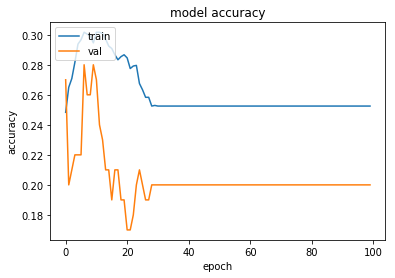

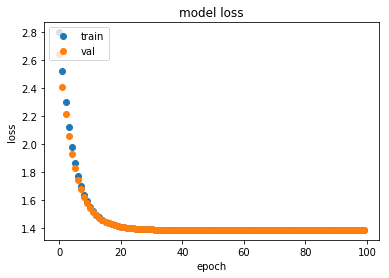

In [9]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()